# Introduction to Band Ratios & Spectral Features

The BandRatios project explore properties of band ratio measures.

Band ratio measures are an analysis measure in which the ratio of power between defined frequency bands is calculated. 

By 'spectral features' we mean 

A 

and how they relate to other spectral measures.

In this introductory notebook, we walk through how band ratio measures and spectral features are computed.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

from fooof.sim import gen_power_spectrum
from fooof.plts import plot_spectrum, plot_spectrum_shading

In [2]:
# Import custom project code
import sys
sys.path.append('../bratios')
from ratios import *
from paths import FIGS_PATHS as fp
from paths import DATA_PATHS as dp

In [3]:
# Settings
SAVE_FIG = True

## What is a Band Ratio

This project explores frequency band ratios, a metric used in spectral analysis since at least the 1960's to characterize cognitive functions such as vigilance, aging, memory among other. In clinical work, band ratios have also been used as a biomarker for diagnosing and monitoring of ADHD, diseases of consciousness, and nervous system disorders such as Parkinson's disease.

Given a power spectrum, a band ratio is the ratio of average power within a band between two frequency ranges. 

Typically, band ratio measures are calculated as:

$ \frac{avg(low\ band\ power)}{avg(high\ band\ power} $

The following cell generates a power spectral density (PSD) and highlights the frequency ranges used to calculate a theta/beta band ratio.

In [4]:
# Settings
theta_band = [4, 8]
beta_band = [20, 30]
freq_range = [1, 35]

# Define default simulation values
ap_def = [0, 1]
theta_def = [6, 0.25, 1]
alpha_def = [10, 0.4, 0.75]
beta_def  = [25, 0.2, 1.5]

In [5]:
# Plot Settings
line_color = 'black'
shade_colors = ['#057D2E', '#0365C0']

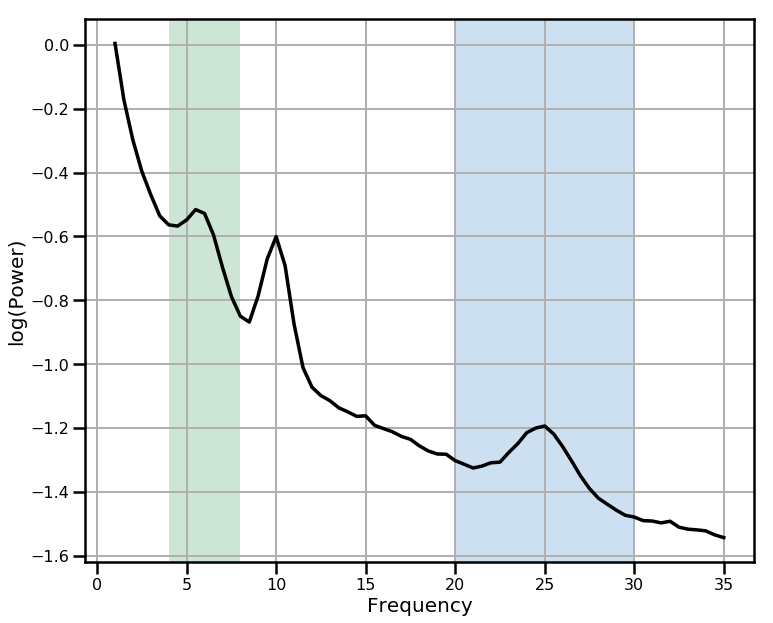

In [6]:
# Generate a simulated power spectrum
fs, ps = gen_power_spectrum(freq_range, ap_def,
                            [theta_def, alpha_def, beta_def])

# Plot and save out our shaded power spectrum plot
fig = plot_spectrum_shading(fs, ps, [theta_band, beta_band],
                            color=line_color, shade_colors=shade_colors,
                            log_powers=True, linewidth=3.5)

if SAVE_FIG: plt.savefig(fp.make_file_path(fp.demo, 'Ratio-example', 'pdf'))

# Calculate theta/beta ratios 

### Average Power Ratio

The most cannonical way of calculating band ratios is to take average power in the low-band and divide it by the average power from the high-band. 

Average power is calculated as the sum of all discrete power values divided by number on power values in that band.

In [7]:
ratio = calc_band_ratio(fs, ps, theta_band, beta_band)
print('Theta-beta ratio is: {:1.4f}'.format(ratio))

Theta-beta ratio is: 5.0270


And there you have it - our first computed frequency band ratio!

# The FOOOF Model

To compare to band ratios, and to measure other spectral features from power spectra, to compare to ratio measures, we will use the [FOOOF](https://github.com/fooof-tools/fooof) library. 

Briefly, the FOOOF algorithm parameterizes neural power spectra, measuring both periodic (oscillatory) and aperiodic features. 

Each identified oscillation is parameterized as a peak, fit as a gaussian, which provides us with a measures of the center frequency, power and bandwidth of that oscillations. 

The aperiodic component is measured by a function of the form $ 1/f^\chi $, in which this $ \chi $ value is referred to as the aperiodic exponent. 

This exponent is equivalent the the negative slope of the power spectrum, when plotted in log-log.  

More details on FOOOF can be found in the associated [paper](https://doi.org/10.1101/299859) and/or on the documentation [site](https://fooof-tools.github.io/fooof/).

In [8]:
# Import the FOOOF object
from fooof import FOOOF

In [9]:
# Load power spectra from an example subject
psd = np.load(dp.make_file_path(dp.eeg_psds, 'A00051886_ec_avg_psds', 'npz'))

# Unpack the loaded power spectra, and select a spectrum to fit
freqs = psd['arr_0']
powers = psd['arr_1'][50]

In [10]:
# Initialize a FOOOF object
fm = FOOOF(verbose=False)

# Fit the FOOOF model
fm.fit(freqs, powers)

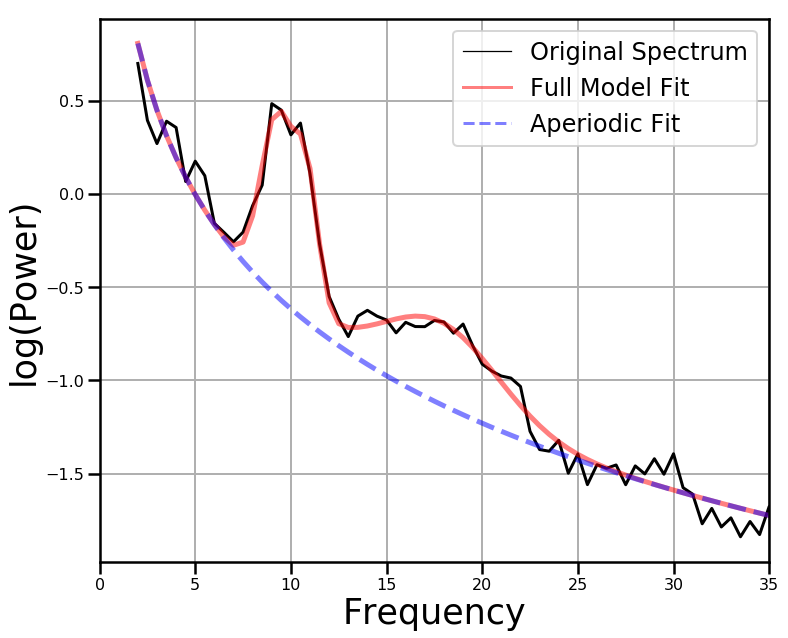

In [11]:
# Plo the power spectrum, with the FOOOF model
fm.plot()

# Plot aesthetic updates
ax = plt.gca()
ax.set_ylabel('log(Power)', {'fontsize':35})
ax.set_xlabel('Frequency', {'fontsize':35})
plt.legend(prop={'size': 24})
for line, width in zip(ax.get_lines(), [3, 5, 5]):
    line.set_linewidth(width)
ax.set_xlim([0, 35]);

# Save out the FOOOF figure
if SAVE_FIG: plt.savefig(fp.make_file_path(fp.demo, 'FOOOF-example', 'pdf'))

In the plot above, the the FOOOF model fit, in red, is plotted over the original data.

The blue dashed line is the fit of the aperiodic component of the data. The aperiodic exponent describes the steepness of this line.

For all future notebooks, the aperiodic exponent reflects values that are simulated and/or measured with the FOOOF model, reflecting the blue line. 

Periodic spectral features are simulation values and/or model fit values from the FOOOF model that measure oscillatory peaks over and above the blue dashed line. 

### NEW

In [12]:
# Generate a simulated power spectrum
fs, ps1 = gen_power_spectrum(freq_range, ap_def,
                             [theta_def, alpha_def, beta_def])

fs, ps2 = gen_power_spectrum(freq_range, ap_def,
                             [alpha_def, beta_def])

In [13]:
fm1 = FOOOF(verbose=False)
fm2 = FOOOF(verbose=False)

In [14]:
def style_plot(ax):
    """Helper function to style plots."""
    
    ax.get_legend().remove()
    ax.grid(False)
    for line in ax.get_lines():
        line.set_linewidth(3.5)
    ax.set_xticks([])
    ax.set_yticks([])

In [15]:
def add_lines(ax, fs, ps, f_val):
    """Helper function to add vertical lines to power spectra plots."""
    
    y_lims = ax.get_ylim()
    ax.plot([f_val, f_val], [y_lims[0], np.log10(ps[fs==f_val][0])],
        'g--', markersize=12, alpha=0.75)
    ax.set_ylim(y_lims)

In [16]:
# ....
f_theta = 6
f_beta = 25

In [17]:
# Fit FOOOF models
fm1.fit(fs, ps1)
fm2.fit(fs, ps2)

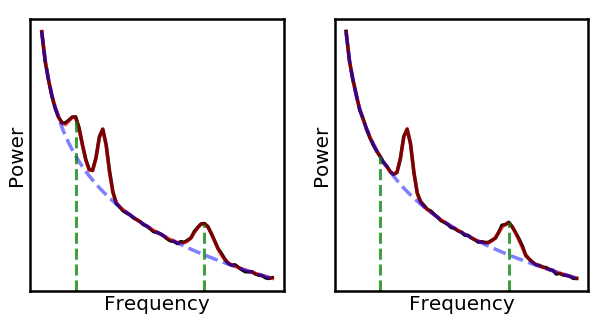

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fm1.plot(ax=axes[0])
style_plot(axes[0])

add_lines(axes[0], fs, ps1, f_theta)
add_lines(axes[0], fs, ps1, f_beta)

fm2.plot(ax=axes[1])
style_plot(axes[1])

add_lines(axes[1], fs, ps2, f_theta)
add_lines(axes[1], fs, ps2, f_beta)

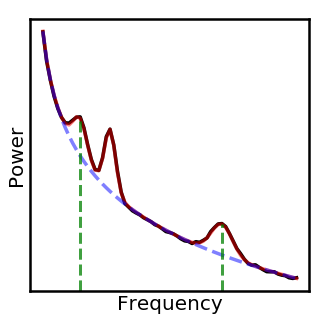

In [19]:
# 
fig, ax = plt.subplots(figsize=(5, 5))
fm1.plot(ax=ax)
style_plot(ax)

#
add_lines(ax, fs, ps1, f_theta)
add_lines(ax, fs, ps1, f_beta)

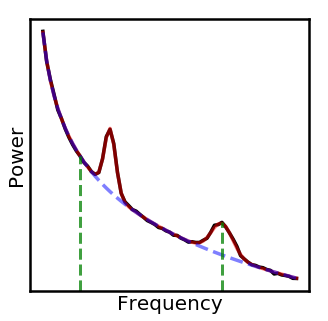

In [20]:
# 
fig, ax = plt.subplots(figsize=(5, 5))
fm2.plot(ax=ax)
style_plot(ax)

#
add_lines(ax, fs, ps2, f_theta)
add_lines(ax, fs, ps2, f_beta)